In [307]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Cleaning of Financial Indicators Dataset

## 1. Data Extraction and Basic Cleaning

In [86]:
# reading datasets into dfs
fi_14_df = pd.read_csv("datasets/2014_Financial_Data.csv")
fi_15_df = pd.read_csv("datasets/2015_Financial_Data.csv")
fi_16_df = pd.read_csv("datasets/2016_Financial_Data.csv")
fi_17_df = pd.read_csv("datasets/2017_Financial_Data.csv")
fi_18_df = pd.read_csv("datasets/2018_Financial_Data.csv")

In [87]:
fi_14_df.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,...,-0.0187,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,NaN,NaN,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,...,0.0618,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,...,0.0211,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,...,0.0257,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1


In [88]:
# rename first column to "Company Ticker"
for df in [fi_14_df, fi_15_df, fi_16_df, fi_17_df, fi_18_df]:
    df.rename(columns = {"Unnamed: 0": "Company Ticker"}, inplace = True)

In [89]:
# get shapes of each dataset
for i, df in enumerate([fi_14_df, fi_15_df, fi_16_df, fi_17_df, fi_18_df], start = 14):
    print(f"Shape of fi_{i}_df: {df.shape}", end = "\n\n")

Shape of fi_14_df: (3808, 225)

Shape of fi_15_df: (4120, 225)

Shape of fi_16_df: (4797, 225)

Shape of fi_17_df: (4960, 225)

Shape of fi_18_df: (4392, 225)



All the years seem to have a rather similar number of entries (3808 to 4960 range). 

In [90]:
for i, df in enumerate([fi_14_df, fi_15_df, fi_16_df, fi_17_df, fi_18_df], start = 14):
    cols_pct_missing = {}
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        cols_pct_missing[col] = round(pct_missing, 5)
    
    top5_cols_pct_missing = dict(sorted(cols_pct_missing.items(), key = lambda x: x[1], reverse = True)[:5])
    print(f"Top 5 missing entry columns of fi_{i}_df: ")
    print(top5_cols_pct_missing, end = "\n\n")

Top 5 missing entry columns of fi_14_df: 
{'operatingCycle': 0.99974, 'cashConversionCycle': 0.99974, 'shortTermCoverageRatios': 0.51366, 'cashFlowToDebtRatio': 0.41912, 'cashFlowCoverageRatios': 0.41912}

Top 5 missing entry columns of fi_15_df: 
{'operatingCycle': 0.99951, 'cashConversionCycle': 0.99951, 'shortTermCoverageRatios': 0.46723, '10Y Shareholders Equity Growth (per Share)': 0.42864, '10Y Revenue Growth (per Share)': 0.4216}

Top 5 missing entry columns of fi_16_df: 
{'operatingCycle': 0.99896, 'cashConversionCycle': 0.99896, 'shortTermCoverageRatios': 0.50386, '10Y Shareholders Equity Growth (per Share)': 0.47655, '10Y Revenue Growth (per Share)': 0.47384}

Top 5 missing entry columns of fi_17_df: 
{'operatingCycle': 0.99899, 'cashConversionCycle': 0.99899, 'shortTermCoverageRatios': 0.50806, '10Y Shareholders Equity Growth (per Share)': 0.47339, '10Y Revenue Growth (per Share)': 0.46815}

Top 5 missing entry columns of fi_18_df: 
{'operatingCycle': 0.99863, 'cashConversio

Since all the datasets have a high proportion (>99%) of `operatingCycle` and `cashConversionCycle` values missing, we remove those columns. We will also create a `Year` column in each dataset corresponding to the year the financial indicators were collected. 

In [91]:
for i, df in enumerate([fi_14_df, fi_15_df, fi_16_df, fi_17_df, fi_18_df], start = 14):
    df.drop(columns = ["operatingCycle", "cashConversionCycle"], inplace = True)
    df.insert(1, "Year", 2000 + i)

In [93]:
fi_14_df.head()

,Company Ticker,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class
0,PG,2014,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,...,-0.0187,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0
1,VIPS,2014,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,...,NaN,NaN,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0
2,KR,2014,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,...,0.0618,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1
3,RAD,2014,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,...,0.0211,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1
4,GIS,2014,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,...,0.0257,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1


## 2. Merging of Datasets

We will merge the datasets into one multi-year dataset (containing financial indicators for 2014 - 2018).

In [229]:
fi_df = pd.concat([fi_14_df, fi_15_df, fi_16_df, fi_17_df, fi_18_df], ignore_index = True)
fi_df.shape

(22077, 228)

In [230]:
ticker_counts = fi_df["Company Ticker"].value_counts()
ticker_counts

CETV    5
SCX     5
AMAT    5
GLMD    5
UMBF    5
       ..
SONC    1
DCT     1
BUFF    1
FFKT    1
HDNG    1
Name: Company Ticker, Length: 4980, dtype: int64

In [231]:
all_5_years_tickers = ticker_counts[ticker_counts == 5].index
all_5_years_tickers

Index(['CETV', 'SCX', 'AMAT', 'GLMD', 'UMBF', 'TRGP', 'AREX', 'BMI', 'UTHR',
       'AXE',
       ...
       'ONDK', 'BLIN', 'FFWM', 'SKYS', 'GHL', 'HFC', 'RWLK', 'FULT', 'STI',
       'MTX'],
      dtype='object', length=3726)

Of the 4980 companies in the dataset, 3726 of them have data for all 5 years. 

We will filter the dataset to only include companies with 5 years of data. 

In [232]:
fy_fi_df = fi_df[fi_df["Company Ticker"].isin(all_5_years_tickers)]
fy_fi_df.shape

(18630, 228)

In [233]:
# getting the feature and outcome columns
feature_cols = fy_fi_df.columns[:-6]
outcome_cols = fy_fi_df.columns[-6:]
feature_cols

Index(['Company Ticker', 'Year', 'Revenue', 'Revenue Growth',
       'Cost of Revenue', 'Gross Profit', 'R&D Expenses', 'SG&A Expense',
       'Operating Expenses', 'Operating Income',
       ...
       '5Y Dividend per Share Growth (per Share)',
       '3Y Dividend per Share Growth (per Share)', 'Receivables growth',
       'Inventory Growth', 'Asset Growth', 'Book Value per Share Growth',
       'Debt Growth', 'R&D Expense Growth', 'SG&A Expenses Growth', 'Sector'],
      dtype='object', length=222)

In [234]:
cols_pct_missing = {}
for col in feature_cols:
    pct_missing = np.mean(fy_fi_df[col].isnull())
    cols_pct_missing[col] = round(pct_missing, 5)

top30_cols_pct_missing = dict(sorted(cols_pct_missing.items(), key = lambda x: x[1], reverse = True)[:30])
print(f"Top 30 missing entry columns of fy_fi_df: ")
print(top30_cols_pct_missing, end = "\n\n")

Top 30 missing entry columns of fy_fi_df: 
{'shortTermCoverageRatios': 0.44514, '10Y Shareholders Equity Growth (per Share)': 0.35115, 'priceEarningsToGrowthRatio': 0.34493, 'dividendPayoutRatio': 0.34493, '10Y Revenue Growth (per Share)': 0.34294, '10Y Net Income Growth (per Share)': 0.34294, '10Y Operating CF Growth (per Share)': 0.34047, 'niperEBT': 0.33451, 'effectiveTaxRate': 0.33451, 'nIperEBT': 0.33451, '10Y Dividend per Share Growth (per Share)': 0.32458, 'Net Debt to EBITDA': 0.30188, 'ebtperEBIT': 0.29705, 'eBTperEBIT': 0.29705, 'Net Debt': 0.27917, 'Other Assets': 0.27424, 'returnOnAssets': 0.24541, 'Return on Tangible Assets': 0.24541, 'priceCashFlowRatio': 0.24525, 'Current ratio': 0.24509, 'returnOnCapitalEmployed': 0.24482, 'ROIC': 0.24482, 'Working Capital': 0.24482, 'enterpriseValueMultiple': 0.2438, 'freeCashFlowOperatingCashFlowRatio': 0.23929, 'cashFlowToDebtRatio': 0.23591, 'cashFlowCoverageRatios': 0.23591, 'Total non-current liabilities': 0.23253, 'Total non-curr

We will filter the dataset to include only columns with less than 20% of their values missing. 

In [235]:
trimmed_feature_cols = [k for k in cols_pct_missing if cols_pct_missing[k] < 0.2]
trimmed_cols = trimmed_feature_cols + outcome_cols.tolist()
trimmed_fy_fi_df = fy_fi_df[trimmed_cols]
trimmed_fy_fi_df.columns

Index(['Company Ticker', 'Year', 'Revenue', 'Revenue Growth',
       'Cost of Revenue', 'Gross Profit', 'R&D Expenses', 'SG&A Expense',
       'Operating Expenses', 'Operating Income',
       ...
       'Debt Growth', 'R&D Expense Growth', 'SG&A Expenses Growth', 'Sector',
       '2015 PRICE VAR [%]', 'Class', '2016 PRICE VAR [%]',
       '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]'],
      dtype='object', length=199)

In [236]:
print(f"The number of feature columns has decreased from {len(feature_cols)}\
 to {len(trimmed_feature_cols)}")

The number of feature columns has decreased from 222 to 193


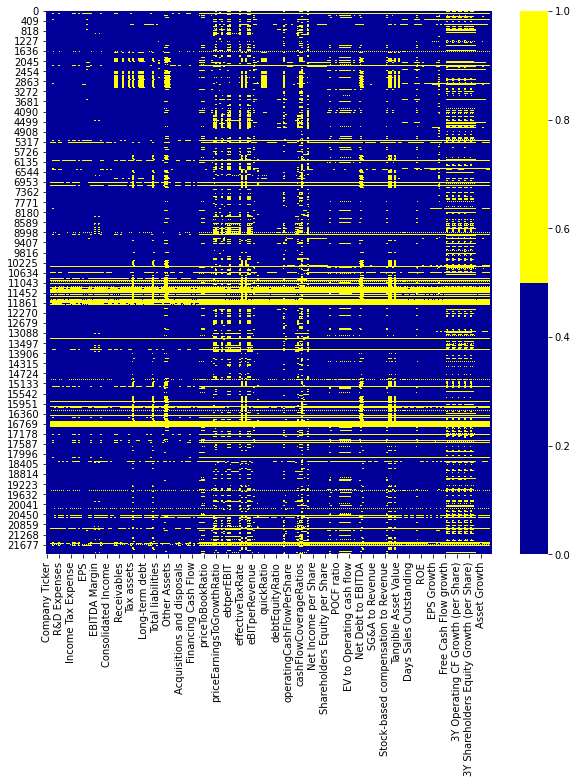

In [237]:
# missing values map BEFORE removing high-missing-value columns (yellow represents missing values)
plt.figure(figsize = (10,10))
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(fi_df[feature_cols].isnull(), cmap=sns.color_palette(colours))
plt.show()

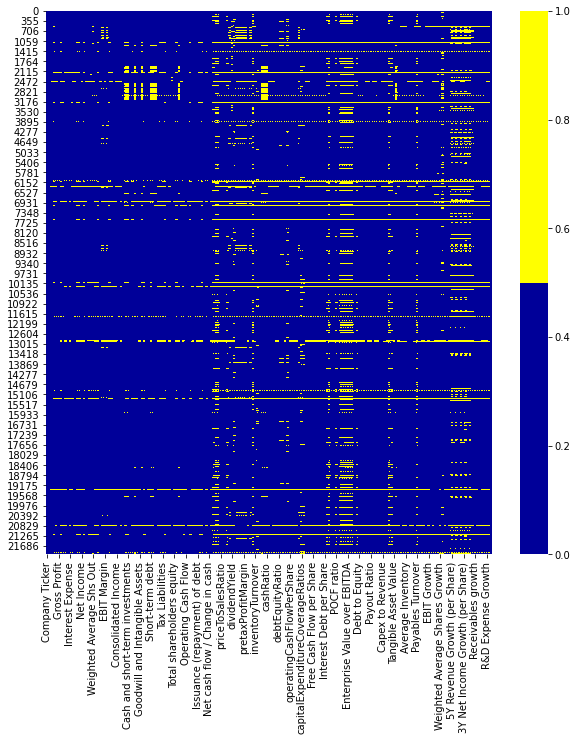

In [238]:
# missing values map AFTER removing high-missing-value columns (yellow represents missing values)
plt.figure(figsize = (10,10))
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(trimmed_fy_fi_df[trimmed_feature_cols].isnull(), cmap=sns.color_palette(colours))
plt.show()

## 3. Handling Outliers

In [291]:
trimmed_fy_fi_df.describe()

,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,2015 PRICE VAR [%],Class,2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%]
count,18630.000000,1.844300e+04,18048.000000,1.834400e+04,1.842500e+04,1.813300e+04,1.838600e+04,1.834900e+04,1.849700e+04,1.834400e+04,...,17768.000000,17901.000000,17991.000000,18017.000000,3.726000e+03,18630.000000,3726.000000,3726.000000,3726.000000,3726.000000
mean,2016.000000,5.271091e+09,3.841217,3.161091e+09,2.096463e+09,1.066460e+08,9.217452e+08,1.464213e+09,6.459718e+08,9.907217e+07,...,0.566468,2.894303,0.253207,0.212207,9.896798e+02,0.553784,108.632267,86.757578,-12.702079,21.590230
std,1.414252,2.113827e+10,328.952127,1.502364e+10,8.298855e+09,7.739922e+08,3.918700e+09,5.924354e+09,3.131871e+09,4.576225e+08,...,63.263571,144.082378,13.233591,3.588407,4.143126e+04,0.497112,3947.403495,3914.717953,80.080562,85.572902
min,2014.000000,-6.276160e+08,-6.872700,-2.986888e+09,-1.280800e+10,-1.098000e+08,-1.401594e+08,-5.495512e+09,-1.933900e+10,-1.710954e+09,...,-3963.131200,-1.051000,-2.662200,-2.099000,-1.003972e+02,0.000000,-99.947830,-99.999406,-99.992266,-99.864779
25%,2015.000000,7.462450e+07,-0.016600,4.177383e+06,3.745400e+07,0.000000e+00,1.919909e+07,3.849223e+07,-3.040000e+06,0.000000e+00,...,-0.098725,-0.066700,0.000000,-0.016400,-2.855907e+01,0.000000,-5.458562,-8.240603,-35.493104,-6.862869
50%,2016.000000,5.129800e+08,0.055850,1.656215e+08,2.255690e+08,0.000000e+00,8.724450e+07,1.671630e+08,4.366700e+07,4.228000e+06,...,0.031900,0.000000,0.000000,0.056300,-5.208147e+00,1.000000,18.104605,11.891346,-15.230046,18.474831
75%,2017.000000,2.562524e+09,0.171825,1.251886e+09,9.790000e+08,1.177300e+07,4.004442e+08,6.625920e+08,2.896080e+08,5.314850e+07,...,0.134900,0.148100,0.000000,0.169800,1.341042e+01,1.000000,41.050972,33.749872,3.096736,40.492109
max,2018.000000,8.482620e+11,42138.663900,3.861020e+11,4.621600e+11,2.883700e+10,1.856830e+11,3.056050e+11,1.565540e+11,3.152300e+10,...,7039.325900,17646.823500,1542.611000,324.926800,2.418601e+06,1.000000,212700.011623,238699.999493,3993.082711,3756.716345


There is a large difference between the maximum value and 75th percentile for some financial indicators (e.g. `Revenue Growth` and `Debt Growth`). This suggests the presence of outliers that need to be addressed. 

Since the financial performance of companies are sector-dependent, outliers will be adjusted to have the values of the 5th or 95th percentile of values for companies in the same sector. 

In [412]:
sector_vc = trimmed_fy_fi_df["Sector"].value_counts()
sector_vc

Financial Services        3240
Healthcare                2865
Technology                2790
Industrials               2470
Consumer Cyclical         2225
Basic Materials           1185
Real Estate               1115
Energy                    1065
Consumer Defensive         800
Utilities                  475
Communication Services     400
Name: Sector, dtype: int64

In [413]:
# drop the columns with non-numeric values and outcome values
feat_fy_fi_df = trimmed_fy_fi_df.drop(columns = ["Company Ticker", 
                                                 "Sector", 
                                                 "Class",
                                                 "2015 PRICE VAR [%]",
                                                 "2016 PRICE VAR [%]",
                                                 "2017 PRICE VAR [%]", 
                                                 "2018 PRICE VAR [%]", 
                                                 "2019 PRICE VAR [%]"
                                                 ])

In [414]:
sector_df_lst = []
for sector in sector_vc.index:
    sector_df = feat_fy_fi_df[trimmed_fy_fi_df["Sector"] == sector]
    upper_qt = sector_df.quantile(0.95)
    lower_qt = sector_df.quantile(0.05)
    
    # setting upper outliers to 95th percentile value
    sector_df = sector_df.mask(feat_fy_fi_df > upper_qt, upper_qt, axis = 1) 
    # setting lower outliers to 5th percentile value
    sector_df = sector_df.mask(feat_fy_fi_df < lower_qt, lower_qt, axis = 1)
    sector_df_lst.append(sector_df)

ol_proc_fy_fi_df = pd.concat(sector_df_lst)

In [415]:
ol_proc_fy_fi_df.describe()

,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,3Y Shareholders Equity Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth
count,18630.000000,1.844300e+04,18048.000000,1.834400e+04,1.842500e+04,1.813300e+04,1.838600e+04,1.834900e+04,1.849700e+04,1.834400e+04,...,16712.000000,15869.000000,17310.000000,17990.000000,17985.000000,18019.000000,17768.000000,17901.000000,17991.000000,18017.000000
mean,2016.000000,3.357710e+09,0.123683,1.782445e+09,1.376074e+09,4.109197e+07,5.653437e+08,9.445167e+08,4.033702e+08,7.153422e+07,...,0.027057,0.007797,0.013612,0.114741,0.037455,0.131455,0.052074,0.110401,0.055326,0.105655
std,1.414252,7.947861e+09,0.416012,4.664015e+09,3.943797e+09,1.534209e+08,1.490606e+09,2.796667e+09,1.058507e+09,2.244206e+08,...,0.161293,0.151978,0.155458,0.448655,0.182147,0.397886,0.402402,0.474646,0.234551,0.234615
min,2014.000000,0.000000e+00,-0.717790,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.036458e+06,-1.251300e+09,0.000000e+00,...,-0.528120,-1.000000,-1.000000,-0.860700,-0.429000,-0.451280,-0.967220,-1.000000,-0.609550,-0.311700
25%,2015.000000,7.462450e+07,-0.016600,5.316995e+06,3.745400e+07,0.000000e+00,1.919909e+07,3.849223e+07,-3.040000e+06,0.000000e+00,...,-0.032300,0.000000,0.000000,-0.050700,0.000000,-0.032650,-0.098725,-0.066700,0.000000,-0.016400
50%,2016.000000,5.129800e+08,0.055850,1.656215e+08,2.255690e+08,0.000000e+00,8.724450e+07,1.671630e+08,4.366700e+07,4.228000e+06,...,0.027400,0.000000,0.000000,0.009550,0.000000,0.044900,0.031900,0.000000,0.000000,0.056300
75%,2017.000000,2.562524e+09,0.171825,1.228678e+09,9.790000e+08,1.071800e+07,3.939750e+08,6.625920e+08,2.896080e+08,5.314850e+07,...,0.100125,0.036300,0.045500,0.191700,0.052500,0.161700,0.134900,0.148100,0.000000,0.169800
max,2018.000000,1.041537e+11,3.464160,4.204978e+10,7.266995e+10,1.233500e+09,2.229990e+10,4.737248e+10,1.357473e+10,4.099304e+09,...,0.524040,0.397500,0.518300,3.132200,0.799360,3.001120,2.293280,1.983840,1.543920,1.370000


Based on the summary statistics above, the difference between the maximum values and the 75th percentile values has been much reduced.

In [416]:
# sorting the index so that the outcome columns can be re-added
ol_proc_fy_fi_df = ol_proc_fy_fi_df.sort_index()

In [417]:
# adding the outcome columns back to the dataset
ol_proc_fy_fi_df.insert(0, "Company Ticker", trimmed_fy_fi_df["Company Ticker"])
ol_proc_fy_fi_df = ol_proc_fy_fi_df.join(trimmed_fy_fi_df[["Sector", 
                                         "Class",
                                         "2015 PRICE VAR [%]",
                                         "2016 PRICE VAR [%]",
                                         "2017 PRICE VAR [%]", 
                                         "2018 PRICE VAR [%]", 
                                         "2019 PRICE VAR [%]"]])

In [418]:
ol_proc_fy_fi_df.head()

,Company Ticker,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Class,2015 PRICE VAR [%],2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%]
0,PG,2014,6.236865e+10,-0.07130,3.903000e+10,2.135020e+10,0.0,8.848118e+09,1.086848e+10,8.659150e+09,...,0.1228,0.000000,-0.153370,Consumer Defensive,0,-9.323276,NaN,NaN,NaN,NaN
1,VIPS,2014,3.734148e+09,0.47266,2.805625e+09,9.285226e+08,9562700.0,3.441414e+08,7.939267e+08,1.345959e+08,...,NaN,0.004385,0.465515,Consumer Defensive,0,-25.512193,NaN,NaN,NaN,NaN
2,KR,2014,6.236865e+10,0.01820,4.101700e+10,2.023700e+10,0.0,8.848118e+09,1.086848e+10,2.725000e+09,...,0.2738,0.000000,0.023400,Consumer Defensive,1,33.118297,NaN,NaN,NaN,NaN
3,RAD,2014,2.552641e+10,0.00530,1.820268e+10,7.323734e+09,0.0,6.561162e+09,6.586482e+09,7.372520e+08,...,-0.0458,0.000000,-0.006000,Consumer Defensive,1,2.752291,NaN,NaN,NaN,NaN
4,GIS,2014,1.790960e+10,0.00760,1.153980e+10,6.369800e+09,0.0,3.474300e+09,3.412400e+09,2.957400e+09,...,0.1025,0.000000,-0.022000,Consumer Defensive,1,12.897715,NaN,NaN,NaN,NaN


## 4. Filling Missing Values

Before filling missing values, the year-based `PRICE VAR [%]` variables (e.g. `2015 PRICE VAR [%]`) must be combined into a single column. That would ensure that the output columns do not have any missing values. 

In [437]:
ol_proc_fy_fi_df["PRICE VAR [%]"] = ol_proc_fy_fi_df.iloc[:, -5:].sum(axis = 1)
ol_proc_fy_fi_df = ol_proc_fy_fi_df.drop(columns = ol_proc_fy_fi_df.columns[-6:-1])

In [440]:
missing_data_vc = ol_proc_fy_fi_df.count()
num_entries  = len(ol_proc_fy_fi_df.index)
missing_data_vc_dct = {feat: num_entries - v for feat, v in zip(missing_data_vc.index, missing_data_vc)}
missing_data_vc_dct

{'Company Ticker': 0,
 'Year': 0,
 'Revenue': 187,
 'Revenue Growth': 582,
 'Cost of Revenue': 286,
 'Gross Profit': 205,
 'R&D Expenses': 497,
 'SG&A Expense': 244,
 'Operating Expenses': 281,
 'Operating Income': 133,
 'Interest Expense': 286,
 'Earnings before Tax': 276,
 'Income Tax Expense': 194,
 'Net Income - Non-Controlling int': 540,
 'Net Income - Discontinued ops': 540,
 'Net Income': 204,
 'Preferred Dividends': 540,
 'Net Income Com': 73,
 'EPS': 258,
 'EPS Diluted': 249,
 'Weighted Average Shs Out': 419,
 'Weighted Average Shs Out (Dil)': 413,
 'Dividend per Share': 540,
 'Gross Margin': 197,
 'EBITDA Margin': 799,
 'EBIT Margin': 260,
 'Profit Margin': 797,
 'Free Cash Flow margin': 553,
 'EBITDA': 306,
 'EBIT': 144,
 'Consolidated Income': 204,
 'Earnings Before Tax Margin': 197,
 'Net Profit Margin': 274,
 'Cash and cash equivalents': 152,
 'Short-term investments': 1286,
 'Cash and short-term investments': 1243,
 'Receivables': 159,
 'Inventories': 329,
 'Total curren

As financial performance is very sector-dependent, we will fill missing values with the median value of a feature among companies in a certain sector. 

In [458]:
cleaned_df = ol_proc_fy_fi_df.groupby(["Sector"]).transform(lambda x: x.fillna(x.median(axis = 0)))
cleaned_df.insert(0, "Company Ticker", ol_proc_fy_fi_df["Company Ticker"])
cleaned_df.insert(len(ol_proc_fy_fi_df.columns) - 3, "Sector", ol_proc_fy_fi_df["Sector"])

## 5. View and Export Cleaned Data

In [460]:
cleaned_df.describe()

,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Class,PRICE VAR [%]
count,18630.000000,1.863000e+04,18630.000000,1.863000e+04,1.863000e+04,1.863000e+04,1.863000e+04,1.863000e+04,1.863000e+04,1.863000e+04,...,18630.000000,18630.000000,18630.000000,18630.000000,18630.000000,18630.000000,18630.000000,18630.000000,18630.000000,1.863000e+04
mean,2016.000000,3.328800e+09,0.121565,1.757352e+09,1.364513e+09,4.002935e+07,5.593383e+08,9.339851e+08,4.010642e+08,7.075809e+07,...,0.012832,0.111507,0.036276,0.128530,0.050853,0.106340,0.053696,0.103877,0.553784,3.205028e+02
std,1.414252,7.913390e+09,0.409648,4.632542e+09,3.923893e+09,1.514990e+08,1.481748e+09,2.777098e+09,1.055095e+09,2.228024e+08,...,0.149882,0.441236,0.179079,0.391646,0.393059,0.465711,0.230693,0.230980,0.497112,1.997525e+04
min,2014.000000,0.000000e+00,-0.717790,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.036458e+06,-1.251300e+09,0.000000e+00,...,-1.000000,-0.860700,-0.429000,-0.451280,-0.967220,-1.000000,-0.609550,-0.311700,0.000000,-2.999982e+02
25%,2015.000000,7.604650e+07,-0.012700,4.310124e+06,3.836356e+07,0.000000e+00,1.951125e+07,3.947925e+07,-2.828250e+06,0.000000e+00,...,0.000000,-0.044475,0.000000,-0.029500,-0.088450,-0.059400,0.000000,-0.012900,0.000000,-4.313462e+01
50%,2016.000000,5.001530e+08,0.055650,1.598150e+08,2.215005e+08,0.000000e+00,8.906200e+07,1.640900e+08,4.425206e+07,4.281000e+06,...,0.000000,0.010600,0.000000,0.045250,0.032500,0.000000,0.000000,0.056800,1.000000,9.299215e+00
75%,2017.000000,2.512072e+09,0.165900,1.186672e+09,9.638195e+08,9.771802e+06,3.850000e+08,6.509048e+08,2.863988e+08,5.210000e+07,...,0.032300,0.181200,0.045475,0.155500,0.127000,0.134250,0.000000,0.163000,1.000000,7.902707e+01
max,2018.000000,1.041537e+11,3.464160,4.204978e+10,7.266995e+10,1.233500e+09,2.229990e+10,4.737248e+10,1.357473e+10,4.099304e+09,...,0.518300,3.132200,0.799360,3.001120,2.293280,1.983840,1.543920,1.370000,1.000000,2.418601e+06


In [461]:
cleaned_df.shape

(18630, 195)

In [446]:
cleaned_df["Class"].value_counts()

1    10317
0     8313
Name: Class, dtype: int64

The `class` column is slightly imbalanced, with slightly more price increases (1) than price decreases (0). 

In [447]:
cleaned_df[cleaned_df.isna().any(axis = 1)]

,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Class,PRICE VAR [%]


In [463]:
cleaned_df["Company Ticker"].value_counts()

CETV    5
DLA     5
WCN     5
FRD     5
CREG    5
       ..
TCO     5
TRCH    5
BGCP    5
FBC     5
JAZZ    5
Name: Company Ticker, Length: 3726, dtype: int64

In [464]:
cleaned_df["Year"].value_counts()

2016    3726
2017    3726
2018    3726
2014    3726
2015    3726
Name: Year, dtype: int64

There are 3726 companies, and 3726 rows per year. 

In [459]:
cleaned_df.head()

,Company Ticker,Year,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Class,PRICE VAR [%]
0,PG,2014,6.236865e+10,-0.07130,3.903000e+10,2.135020e+10,0.0,8.848118e+09,1.086848e+10,8.659150e+09,...,-0.01870,-0.02170,0.0359,0.0316,0.1228,0.000000,-0.153370,Consumer Defensive,0,-9.323276
1,VIPS,2014,3.734148e+09,0.47266,2.805625e+09,9.285226e+08,9562700.0,3.441414e+08,7.939267e+08,1.345959e+08,...,0.02475,0.01405,0.0358,0.0396,0.0000,0.004385,0.465515,Consumer Defensive,0,-25.512193
2,KR,2014,6.236865e+10,0.01820,4.101700e+10,2.023700e+10,0.0,8.848118e+09,1.086848e+10,2.725000e+09,...,0.06180,0.09810,0.1886,0.3268,0.2738,0.000000,0.023400,Consumer Defensive,1,33.118297
3,RAD,2014,2.552641e+10,0.00530,1.820268e+10,7.323734e+09,0.0,6.561162e+09,6.586482e+09,7.372520e+08,...,0.02110,-0.05100,-0.0189,0.1963,-0.0458,0.000000,-0.006000,Consumer Defensive,1,2.752291
4,GIS,2014,1.790960e+10,0.00760,1.153980e+10,6.369800e+09,0.0,3.474300e+09,3.412400e+09,2.957400e+09,...,0.02570,0.00900,0.0215,0.0274,0.1025,0.000000,-0.022000,Consumer Defensive,1,12.897715


In [467]:
cleaned_df.to_csv("datasets/cleaned_df.csv")